In [1]:
import torch
from model_triton import *

dloss_dx = torch.randn((2, 512, 3072), device="cuda")
aa = torch.randn((2, 512, 3072), device="cuda")
#aa = aa.view(-1)
N = 100

fn_naive = t_gelu_bkwd2
fn_jit = torch.compile(fn_naive)
fn_jit(dloss_dx, aa) # burn it

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Torch-Compiled Region        55.68%       5.494ms        82.45%       8.135ms      81.350us       0.000us         0.00%       8.618ms      86.180us           100  
    triton_poi_fused_add_mul_pow_rsub_tanh_0        17.77%       1.753ms        24.30%       2.398ms      23.980us       7.834ms       100.00%       8.540ms      85.400us           100  
                            triton__0d1d2d3d         0.00%      

STAGE:2025-01-21 10:31:44 65120:65120 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-21 10:31:44 65120:65120 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-21 10:31:44 65120:65120 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [2]:
def t_gelu_bkwd(x): # TODO XXX XXX: I think maths can be simplified here? 
    k = math.sqrt(2/math.pi)
    tanh_term = torch.tanh(k * (x + 0.044715 * torch.pow(x,3)))
    tanh_dx = (1 - torch.pow(tanh_term, 2)) * k * ( 1 + 3 * 0.044715 * torch.pow(x,2))
    
    return 0.5 * (1 + tanh_term) + 0.5 * x * tanh_dx

import triton
import triton.language as tl

# TODO T: explore using tl.erf for implementing this
@triton.jit
def tanh_k(x):
    return 2 * tl.sigmoid(2 * x) - 1

# TODO T: Do it in-place?
@triton.jit
def t_gelu_bkwd2_k(dloss_dx_ptr,
                    x_ptr,
                    output_ptr,
                    n_elements,
                    BLOCK_SIZE: tl.constexpr,
                    # NOTE: `constexpr` so it can be used as a shape value. <- TODO T: think about it
                    ):
    pid = tl.program_id(axis=0)  
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    dloss_dx = tl.load(dloss_dx_ptr + offsets, mask=mask)
    x = tl.load(x_ptr + offsets, mask=mask)
    k = tl.sqrt(2/math.pi) # TODO T: compute one as contant outside
    x2 = x * x
    tanh_term = tanh_k(k * (x + 0.044715 * x * x2)) # TODO XXX XXX: Simplify maths
    tanh_dx = (1 - tanh_term * tanh_term) * k * (1 + 3 * 0.044715 * x2)
    jac = 0.5 * (1 + tanh_term) + 0.5 * x * tanh_dx
    output = dloss_dx * jac
    tl.store(output_ptr + offsets, output, mask=mask)
    
def t_gelu_bkwd2_t(dloss_dx: torch.Tensor, x: torch.Tensor):
    # TODO T: do it in 3D instead
    dloss_dx_1d = dloss_dx.view(-1)
    x_1d = x.view(-1)  
    output = torch.empty_like(x_1d)
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    t_gelu_bkwd2_k[grid](dloss_dx, x_1d, output, n_elements, BLOCK_SIZE=1024)
    return output.reshape(x.shape)

fn_t = t_gelu_bkwd2_t

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
    t_gelu_bkwd2_k_0d1d2d3d         0.00%       0.000us         0.00%       0.000us       0.000us       7.914ms       100.00%       7.914ms      79.140us           100  
                 aten::view         7.05%     300.000us         7.05%     300.000us       1.000us       0.000us         0.00%       0.000us       0.000us           300  
           aten::empty_like         5.64%     240.000us        66.57%       2.834ms      28.340us       0.000us         0.00%       0.000us       0.0

STAGE:2025-01-21 10:31:44 65120:65120 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-21 10:31:44 65120:65120 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-21 10:31:44 65120:65120 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


In [3]:
res1 = fn_jit(dloss_dx, aa)
print(f'res1', res1.shape, res1)
res2 = fn_t(dloss_dx, aa)
print(f'res2', res2.shape, res2)

res1 torch.Size([2, 512, 3072]) tensor([[[ 0.0129,  0.5909,  0.8524,  ...,  0.4920,  0.3972,  0.0195],
         [-0.5813,  1.0128, -0.1034,  ...,  0.6286,  0.0270, -1.7619],
         [-0.0969, -0.1962, -1.1235,  ...,  0.1040,  0.0630, -0.0295],
         ...,
         [ 0.0667,  0.0478, -0.3204,  ..., -0.0590, -0.4764,  0.0160],
         [ 0.0342,  0.0219, -0.3152,  ..., -0.4697, -0.0022, -0.2685],
         [ 0.0422,  0.0282,  0.9215,  ..., -0.1400,  0.0809,  0.4046]],

        [[-0.0984,  0.5713, -0.0710,  ..., -0.0516,  0.9907,  0.0267],
         [-1.1496,  0.0020, -0.1971,  ...,  1.3772, -0.0420, -1.1024],
         [-0.1191,  0.6651, -0.2096,  ..., -0.2850, -0.0212,  0.1259],
         ...,
         [ 0.4242,  0.2788, -0.5770,  ...,  0.3354,  0.3744, -0.0195],
         [ 1.1129, -0.1250, -0.0096,  ...,  0.2076,  0.0698, -0.0183],
         [ 0.7973, -0.0390, -0.0462,  ...,  0.0319, -0.0623,  1.8211]]],
       device='cuda:0')
res2 torch.Size([2, 512, 3072]) tensor([[[ 0.0129,  0.5909, 

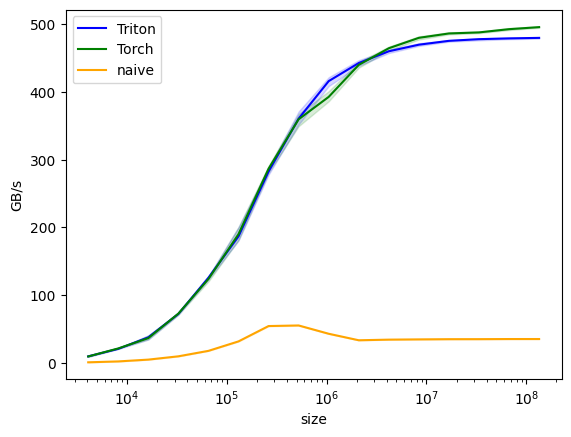

t_gelu_fwd:
           size      Triton       Torch      naive
0        4096.0   10.105264    9.941748   1.343832
1        8192.0   21.186207   21.787235   2.650561
2       16384.0   38.161490   37.012049   5.319481
3       32768.0   72.710056   73.142858  10.172185
4       65536.0  126.030769  124.121216  18.217939
5      131072.0  186.889738  190.143141  32.167539
6      262144.0  282.482757  286.600589  54.765458
7      524288.0  360.417951  359.429633  55.641152
8     1048576.0  415.661740  392.431159  43.425291
9     2097152.0  442.312702  439.593068  33.827942
10    4194304.0  459.632966  464.108592  34.743300
11    8388608.0  469.336521  479.458626  35.117587
12   16777216.0  475.024034  485.901766  35.414495
13   33554432.0  477.493634  487.445252  35.453363
14   67108864.0  478.628801  492.212173  35.635121
15  134217728.0  479.390135  495.214767  35.650150


In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_gelu_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    dloss_dx = torch.rand(size, device="cuda", dtype=torch.float32)    
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [5]:
aa.numel()

3145728